In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
X_train_orig = mnist.train.images
Y_train_orig = mnist.train.labels
X_test_orig = mnist.test.images
Y_test_orig = mnist.test.labels

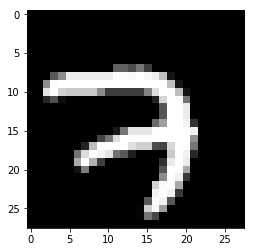

In [5]:
plt.gray()
plt.imshow(X_train_orig[0].reshape(28, 28))
plt.show()

In [6]:
X_train = X_train_orig.reshape(-1, 28, 28, 1)
X_test = X_test_orig.reshape(-1, 28, 28, 1)

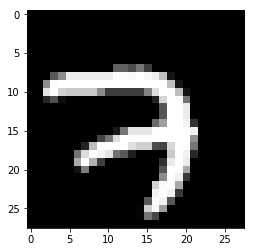

In [7]:
plt.gray()
plt.imshow(X_train[0][:,:,0])
plt.show()

In [8]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    if X.shape[0] != Y.shape[0]:
        raise Exception("Number of examples do not match for X and Y")
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        indices = permutation[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_X = X[indices,:,:,:]
        mini_batch_Y = Y[indices,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        indices = permutation[num_complete_minibatches * mini_batch_size : m]
        mini_batch_X = X[indices,:,:,:]
        mini_batch_Y = Y[indices,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [9]:
mini_batches = random_mini_batches(X_train, Y_train_orig)

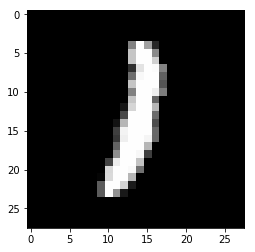

In [10]:
plt.gray()
plt.imshow(mini_batches[0][0][0,:,:,0])
plt.show()

In [11]:
Y_train_orig.shape

(55000, 10)

In [12]:
mini_batches[0][1][0]

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [13]:
def create_placeholders(n_H0, n_W0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(dtype=tf.float32, shape=(None, n_H0, n_W0, 1))
    Y = tf.placeholder(dtype=tf.float32, shape=(None, n_y))
    
    return X, Y

In [14]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [5, 5, 1, 20] CONV1
                        W2 : [5, 5, 20, 50] CONV2
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)
    W1 = tf.get_variable('W1', [5, 5, 1, 20], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable('W2', [5, 5, 20, 50], initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [15]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the LeNet5:
    Conv1 -> RELU -> MaxPool1 -> Conv2 -> RELU -> MaxPool2 -> FC1 -> RELU -> FC2 -> Softmax
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z4 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

    P2 = tf.contrib.layers.flatten(P2)

    # 500 nodes is the the FC1
    Z3 = tf.contrib.layers.fully_connected(P2, 500, activation_fn=None)
    A3 = tf.nn.relu(Z3)
    
    Z4 = tf.contrib.layers.fully_connected(A3, 10, activation_fn=None)

    return Z4

In [16]:
def compute_cost(Z4, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z4, labels = Y))
    
    return cost

In [17]:
def forward_propagation_for_predict(X, parameters):
    """
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3", "W4", "b4"
                  the shapes are given in initialize_parameters

    Returns:
    Z4 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
    W4 = parameters['W4']
    b4 = parameters['b4'] 

    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    A3 = tf.nn.relu(Z3)
    Z4 = tf.add(tf.matmul(W4, A3), b4)
    
    return Z4

def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    W4 = tf.convert_to_tensor(parameters["W4"])
    b4 = tf.convert_to_tensor(parameters["b4"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3,
              "W4": W4,
              "b4": b4}
    
    x = tf.placeholder("float", [784, 1])
    
    z4 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z4)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [18]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 28, 28, 1)
    Y_train -- test set, of shape (None, n_y = 10)
    X_test -- training set, of shape (None, 28, 28, 1)
    Y_test -- test set, of shape (None, n_y = 10)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    X, Y = create_placeholders(n_H0, n_W0, n_y)
    parameters = initialize_parameters()
    Z4 = forward_propagation(X, parameters)
    cost = compute_cost(Z4, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z4, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        return train_accuracy, test_accuracy, parameters

In [19]:
_, _, parameters = model(X_train, Y_train_orig, X_test, Y_test_orig, minibatch_size = 512)

Cost after epoch 0: 0.485881


KeyboardInterrupt: 

In [ ]:
parameters

In [ ]:
import json

json.dumps(parameters)